In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import json
import scienceplots
import wandb
import pickle
from matplotlib.colors import to_rgba

from copy import deepcopy

from src.problem import Instance
from src.utils import load_all_results

import os 
os.environ["PATH"] += os.pathsep + '/home/bruno/texlive/2023/bin/x86_64-linux/'

plt.style.use(['science','vibrant'])
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

instances_dir = Path('../data/raw/')
results_dir = Path('../data/results/')
opts_dir = Path('../data/interim')

# scheduling example

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-10


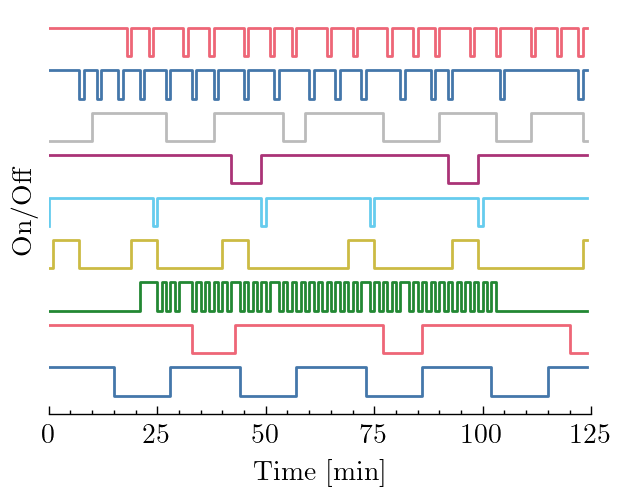

In [3]:
instance_fpath = next(instances_dir.glob('125_9_*.json'))
instance = Instance.from_file(instance_fpath)

opt_fp = opts_dir/(instance_fpath.name.replace('.json', '_opt.npz'))
obj, gap, runtime, X = np.load(opt_fp).values()

x = X[instance.vars_names.find('x(') >= 0]
x = x.reshape((instance.jobs, instance.T))

for i, j in enumerate(x):
    plt.step(np.arange(instance.T), j + i*1.5, label=i)

plt.xlim(0,instance.T)
plt.ylabel('On/Off')
plt.xlabel('Time [min]')

ax = plt.gca()
ax.set_yticks([])
ax.set_xticks(np.linspace(0,125,6), )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.gcf().set_size_inches((6,6))

plt.tick_params(top=False, which='both')
plt.savefig('../schedule_example.pdf')
plt.show()

# feasibility classification

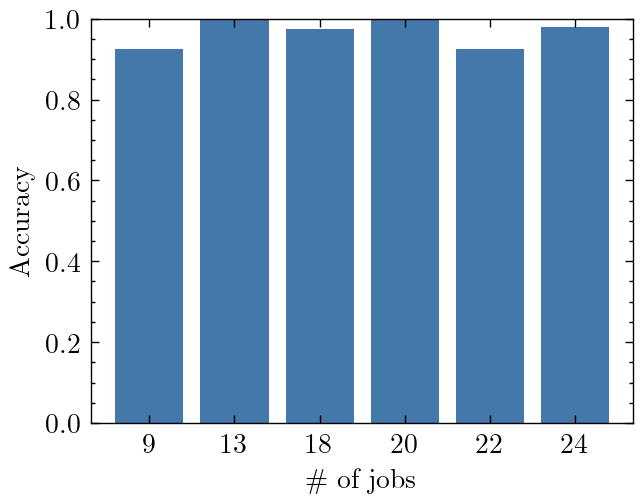

In [4]:
from collections import OrderedDict

accuracies = OrderedDict()
for size in [9,13,18,20,22,24]:
    runs = wandb.Api().runs(path='brunompac/sat-gnn', filters={'group': f'FeasClass-AcrossInstances-{size}'}, order='-created_at')
    run = runs[0]

    accuracies[size] = run.summary['val_loss_accuracy']

plt.bar(np.arange(len(accuracies.values())), accuracies.values(), tick_label=list(accuracies.keys()))

plt.xlabel('\# of jobs')
plt.ylabel('Accuracy')

plt.ylim(0,1)
# plt.minorticks_off()
plt.gcf().gca().set_xticks(list(), minor=True)
plt.savefig('../accuracy_classification_across_instances.pdf')
plt.show()

# optimality prediction

Optimals
0.28874673982384386


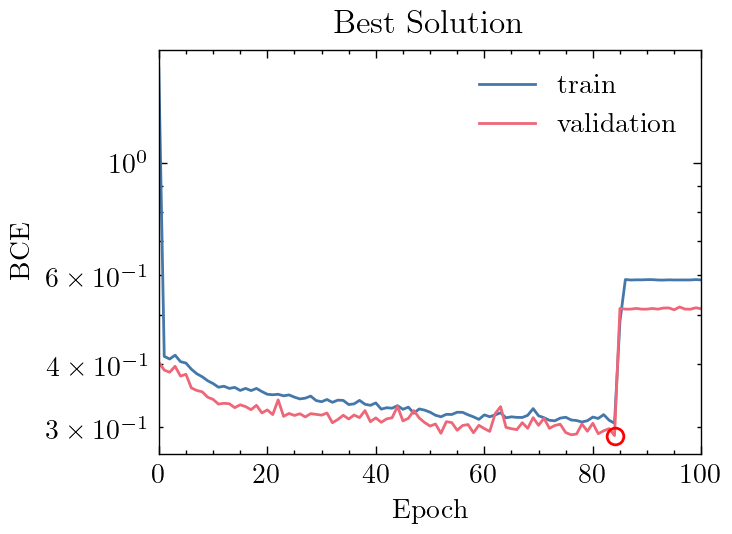

In [50]:
net_id = 'gbmooeqh'

api = wandb.Api()
run = api.run('brunompac/sat-gnn/'+net_id)
training_type = run.group[len('Best-'):]

df = run.history()
train_loss = df.train_loss.values
val_loss = df.val_loss.values

best_val_loss = run.summary['best_val']

fig, ax = plt.subplots()

ax.plot(train_loss, label='train')
ax.plot(val_loss, label='validation')
ax.plot(np.where(val_loss == best_val_loss)[0], [best_val_loss], 'o', color='r', fillstyle='none')

print(training_type)
print(best_val_loss)

plt.title('Best Solution')
plt.ylabel('BCE')
plt.xlabel('Epoch')
plt.legend()
plt.yscale('log')
plt.xlim(0,100)
plt.savefig('../training_curve_optimal.pdf')
plt.show()

MultiTarget
0.2451411026189783


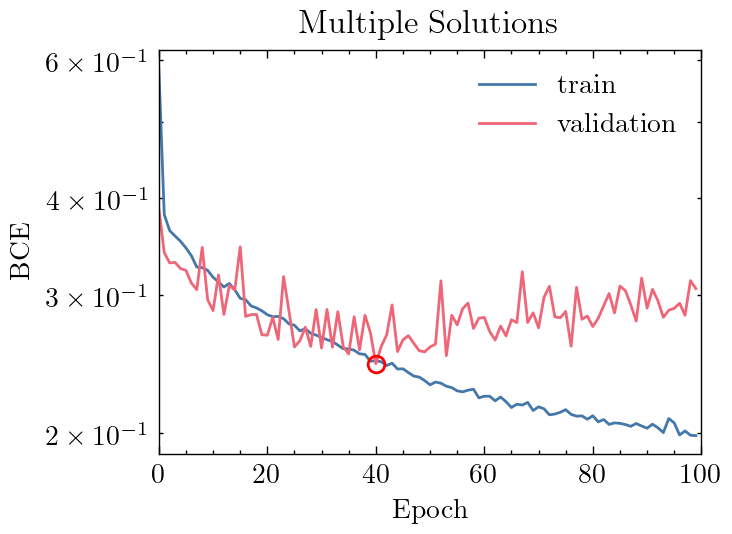

In [51]:
net_id = 'xae9giql'

api = wandb.Api()
run = api.run('brunompac/sat-gnn/'+net_id)
training_type = run.group[len('Best-'):]

df = run.history()
train_loss = df.train_loss.values
val_loss = df.val_loss.values

best_val_loss = run.summary['best_val']

fig, ax = plt.subplots()

ax.plot(train_loss * 500, label='train')
ax.plot(val_loss * 500, label='validation')
ax.plot(np.where(val_loss == best_val_loss)[0], [best_val_loss*500], 'o', color='r', fillstyle='none')

print(training_type)
print(best_val_loss * 500)

plt.title('Multiple Solutions')
plt.ylabel('BCE')
plt.xlabel('Epoch')
plt.legend()
plt.yscale('log')
plt.xlim(0,100)
plt.savefig('../training_curve_multi.pdf')
plt.show()

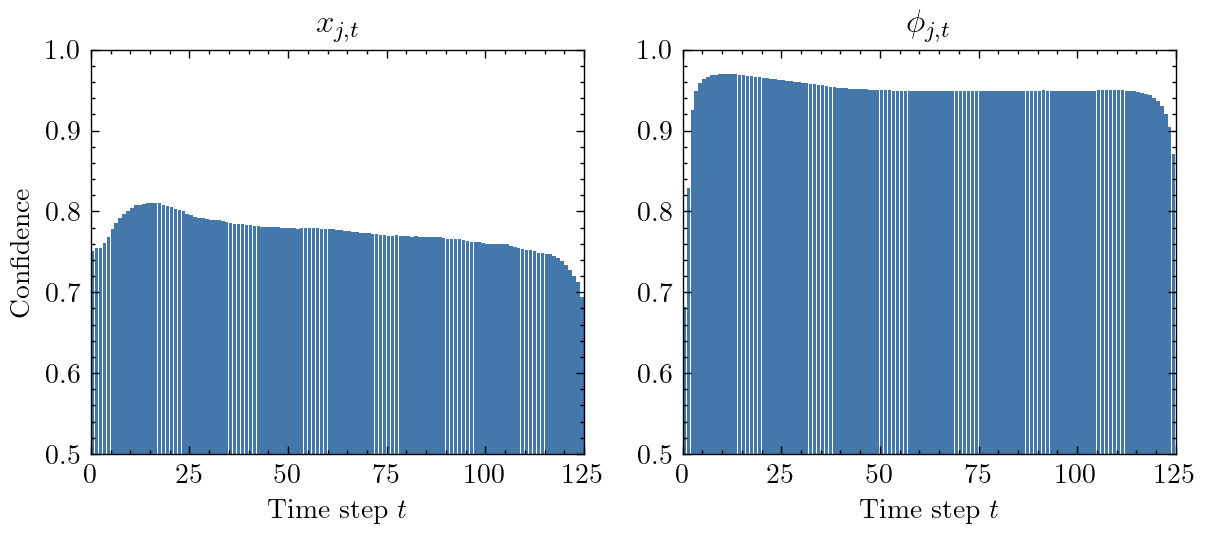

In [72]:
def var_conf_plot(conf, plot_title, filename=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.bar(np.arange(125), conf.mean(0), align='edge', width=.9)
    ax.set_xlim(0,125)
    ax.set_ylim(0.5,1)
    # plt.title('$x_{j,t}$ variables')
    ax.set_title(plot_title)
    # ax.set_ylabel('Confidence')
    ax.set_xlabel('Time step $t$')

    # if filename is not None:
    #     plt.savefig(filename, dpi=500)

    # plt.show()

with open('../gbmooeqh_preds_test.pkl', 'rb') as f:
    preds = pickle.load(f)

df = pd.DataFrame(preds)
# df['x_hat'] = df['x_hat'].map(lambda t: t.numpy())
df['conf'] = df['x_hat'].map(lambda x: np.where(x > 1-x, x, 1-x))

X_confs = list()
Phi_confs = list()
for conf in df['conf'].values:
    X_confs.append(conf.reshape(-1, 125)[::2])
    Phi_confs.append(conf.reshape(-1, 125)[1::2])

X_conf = np.vstack(X_confs)
Phi_conf = np.vstack(Phi_confs)

fig, axs = plt.subplots(1,2)
fig.set_size_inches(7, 2.625)

var_conf_plot(X_conf, '$x_{j,t}$', ax=axs[0])
var_conf_plot(Phi_conf, '$\phi_{j,t}$', ax=axs[1])

axs[0].set_ylabel('Confidence')

fig.savefig('../optimals_confidence.pdf', dpi=500)
fig.show()

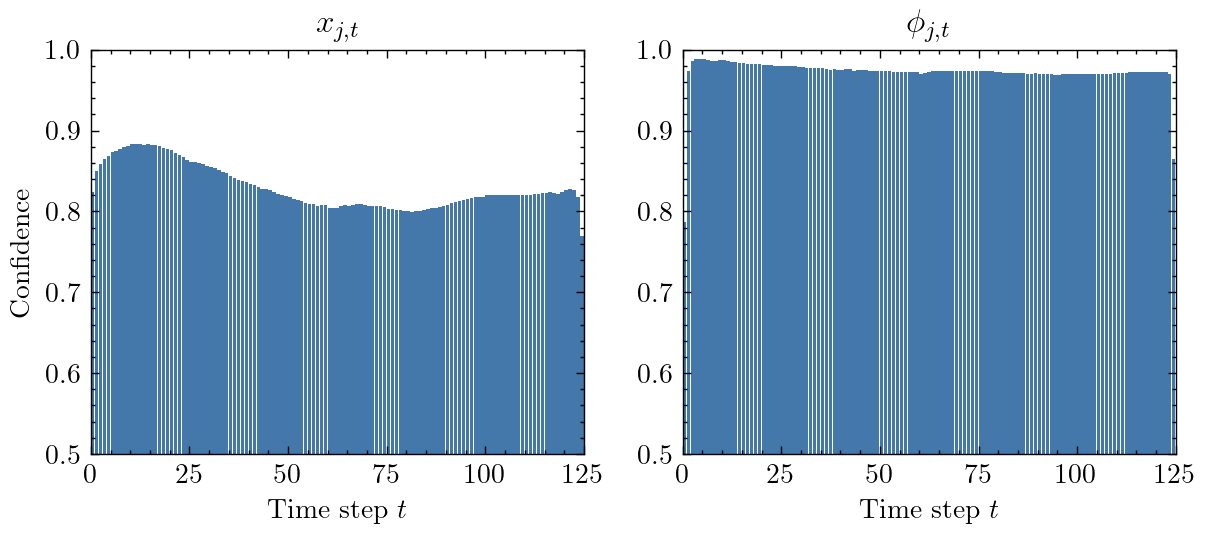

In [73]:
with open('../xae9giql_preds_test.pkl', 'rb') as f:
    preds = pickle.load(f)

df = pd.DataFrame(preds)
# df['x_hat'] = df['x_hat'].map(lambda t: t.numpy())
df['conf'] = df['x_hat'].map(lambda x: np.where(x > 1-x, x, 1-x))

X_confs = list()
Phi_confs = list()
for conf in df['conf'].values:
    X_confs.append(conf.reshape(-1, 125)[::2])
    Phi_confs.append(conf.reshape(-1, 125)[1::2])

X_conf = np.vstack(X_confs)
Phi_conf = np.vstack(Phi_confs)

fig, axs = plt.subplots(1,2)
fig.set_size_inches(7, 2.625)

var_conf_plot(X_conf, '$x_{j,t}$', ax=axs[0])
var_conf_plot(Phi_conf, '$\phi_{j,t}$', ax=axs[1])

axs[0].set_ylabel('Confidence')

fig.savefig('../multiple_confidence.pdf', dpi=500)
fig.show()

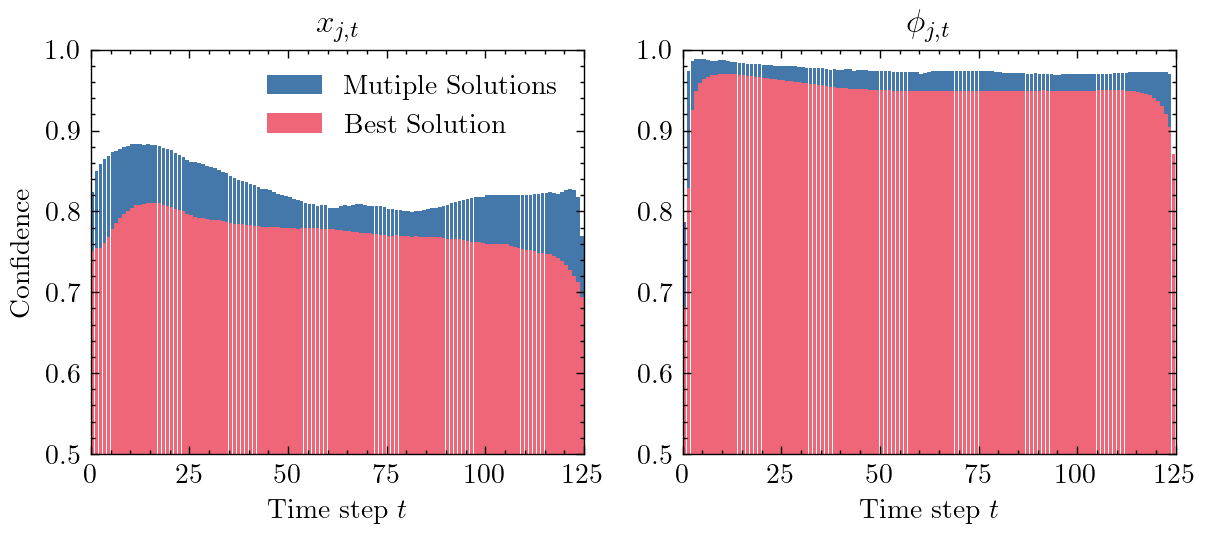

In [71]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(7, 2.625)

with open('../xae9giql_preds_test.pkl', 'rb') as f:
    preds = pickle.load(f)

df = pd.DataFrame(preds)
# df['x_hat'] = df['x_hat'].map(lambda t: t.numpy())
df['conf'] = df['x_hat'].map(lambda x: np.where(x > 1-x, x, 1-x))

X_confs = list()
Phi_confs = list()
for conf in df['conf'].values:
    X_confs.append(conf.reshape(-1, 125)[::2])
    Phi_confs.append(conf.reshape(-1, 125)[1::2])

X_conf = np.vstack(X_confs)
Phi_conf = np.vstack(Phi_confs)

axs[0].bar(np.arange(125), X_conf.mean(0), align='edge', width=.9, label='Mutiple Solutions')
axs[1].bar(np.arange(125), Phi_conf.mean(0), align='edge', width=.9, label='Mutiple Solutions')

with open('../gbmooeqh_preds_test.pkl', 'rb') as f:
    preds = pickle.load(f)

df = pd.DataFrame(preds)
# df['x_hat'] = df['x_hat'].map(lambda t: t.numpy())
df['conf'] = df['x_hat'].map(lambda x: np.where(x > 1-x, x, 1-x))

X_confs = list()
Phi_confs = list()
for conf in df['conf'].values:
    X_confs.append(conf.reshape(-1, 125)[::2])
    Phi_confs.append(conf.reshape(-1, 125)[1::2])

X_conf = np.vstack(X_confs)
Phi_conf = np.vstack(Phi_confs)

axs[0].bar(np.arange(125), X_conf.mean(0), align='edge', width=.9, label='Best Solution')
axs[1].bar(np.arange(125), Phi_conf.mean(0), align='edge', width=.9, label='Best Solution')

axs[0].set_xlim(0,125)
axs[0].set_ylim(0.5,1)
axs[0].set_title('$x_{j,t}$')
axs[0].set_xlabel('Time step $t$')

axs[1].set_xlim(0,125)
axs[1].set_ylim(0.5,1)
axs[1].set_title('$\phi_{j,t}$')
axs[1].set_xlabel('Time step $t$')

axs[0].set_ylabel('Confidence')

axs[0].legend()
fig.savefig('../confidences.pdf', dpi=500)
fig.show()

# test results

In [3]:
T = 125
TIME_BUDGET = 120

net_ids = {
    'Baseline': 'baseline',
    'Optimals': 'gbmooeqh',
    'MultiTarget': 'xae9giql',
}

hps = {
    'Baseline':{
        'obj': {
            'bs': 'bs_0',
        },
        'feas': {
            'bs': 'bs_0',
        }
    },
    'Optimals':{
        'obj': {
            'ws': 'ws_750',
            'ef': 'ef_500',
            'tr': 'tr_1000_5',
        },
        'feas': {
            'ws': 'ws_1000',
            'ef': 'ef_750',
            'tr': 'tr_1000_1',
        }
    },
    'MultiTarget':{
        'obj': {
            'ws': 'ws_1750',
            'ef': 'ef_1000',
            'tr': 'tr_1250_1',
        },
        'feas': {
            'ws': 'ws_1500',
            'ef': 'ef_1250',
            'tr': 'tr_1750_1',
        }
    }
}

In [20]:
dfs = list()
for m in hps.keys():
    for p in hps[m].keys():
        for h, sn in hps[m][p].items():
            fpaths = [fp for fp in results_dir.glob(f'{net_ids[m]}_{sn}_{T}_*.json') if int(fp.name.split('_')[-1][:-len('.json')]) >= 20]
            if len(fpaths) > 0:
                df = load_all_results(f"{net_ids[m]}_{hps[m][p][h]}", results_dir, opts_dir, test=True)
                df['model'] = m
                df['goal'] = p
                df['heuristic'] = h
                df['sn'] = hps[m][p][h]
                dfs.append(df)
df = pd.concat(dfs)
df['rel_obj'] = df['objective'] / df['opt_obj']

In [41]:
df['plot_label'] = 'Baseline'
df.loc[df['model'] == 'MultiTarget', 'plot_label'] = 'MS'
df.loc[df['model'] == 'Optimals', 'plot_label'] = 'OS'
df.loc[df['heuristic'] == 'ws', 'plot_label'] = df['plot_label'][df['heuristic'] == 'ws'] + '+Warm-start'
df.loc[df['heuristic'] == 'ef', 'plot_label'] = df['plot_label'][df['heuristic'] == 'ef'] + '+Early-fix'
df.loc[df['heuristic'] == 'tr', 'plot_label'] = df['plot_label'][df['heuristic'] == 'tr'] + '+Trust region'

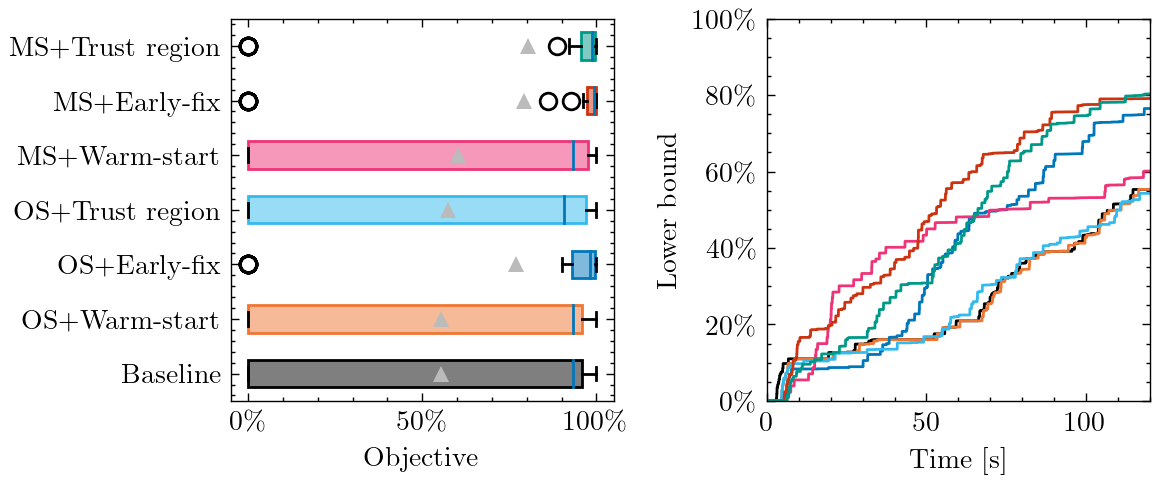

In [97]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(6, 2.625)

def get_labels_values(goal, column):
    df_ = df[df['goal'] == goal]

    labels = list()
    valuess = list()
    for m, h in df_[['model', 'heuristic']].drop_duplicates().values:
        label = df_[(df_['model'] == m) & (df_['heuristic'] == h)]['plot_label'].values[0]
        labels.append(label)
        valuess.append(
            df_[(df_['model'] == m) & (df_['heuristic'] == h)][column].values
        )
    
    return labels, valuess

def plot_bounds(goal, ax):
    df_ = df[df['goal'] == goal]

    for m, h in df_[['model', 'heuristic']].drop_duplicates().values:
        label = df_[(df_['model'] == m) & (df_['heuristic'] == h)]['plot_label'].values[0]

        curve = df_[(df_['model'] == m) & (df_['heuristic'] == h)]['primal_curve'].mean()
        dt = TIME_BUDGET / (len(curve)-1)
        auc = np.sum(curve * dt)
        x = np.arange(len(curve)) * dt

        if m == 'Baseline':
            ax.plot(x, curve, color='black', label=f"Baseline ({auc:.2f})")
        else:
            ax.plot(x, curve, label=f"{label} ({auc:.2f})")
    ax.set_ylabel('Lower bound')
    ax.set_xlabel('Time [s]')
    ax.set_xlim(0,TIME_BUDGET)
    ax.set_ylim(0,1)
    # ax.grid()
    # ax.legend()

labels, values = get_labels_values('obj', 'rel_obj')

bar_colors = [colors[-1],] + [colors[1],] * 3 + [colors[3],] * 3

bplot = axs[0].boxplot(values, labels=labels, vert=False, showmeans=True, patch_artist=True,
                       meanprops={'markerfacecolor': colors[6], 'markeredgewidth': 0})

for patch, color in zip(bplot['boxes'], ['black',]+colors):
    c = to_rgba(color)
    c = (*c[:3], 0.5)
    patch.set_edgecolor(color)
    patch.set_facecolor(c)

axs[0].set_xlabel('Objective')

plot_bounds('obj', axs[1])

axs[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

fig.tight_layout()
fig.savefig('../heuristic_test_obj.pdf')
fig.show()

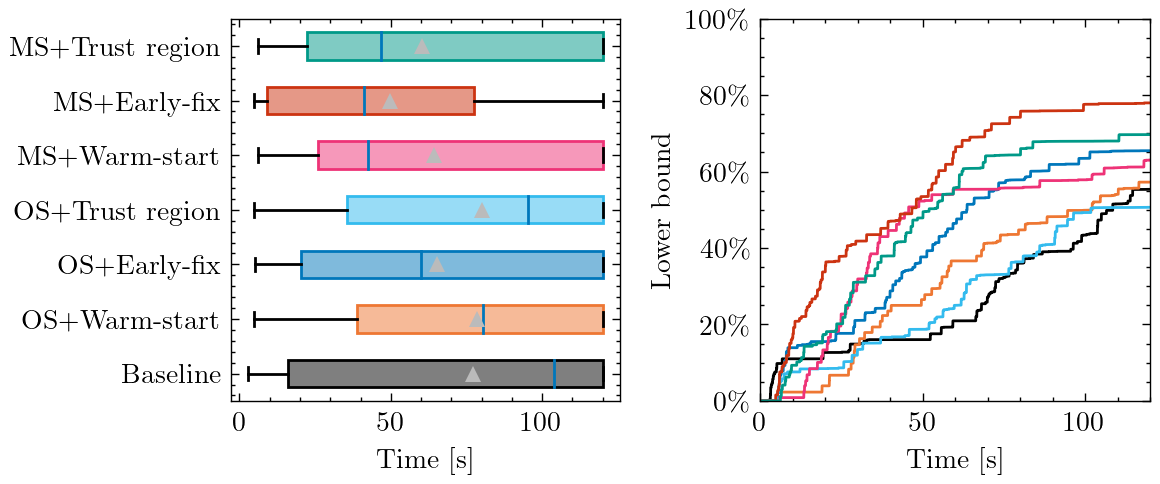

In [100]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(6, 2.625)

labels, values = get_labels_values('feas', 'time_to_feasible')

bar_colors = [colors[-1],] + [colors[1],] * 3 + [colors[3],] * 3

bplot = axs[0].boxplot(values, labels=labels, vert=False, showmeans=True, patch_artist=True,
                       meanprops={'markerfacecolor': colors[6], 'markeredgewidth': 0})

for patch, color in zip(bplot['boxes'], ['black',]+colors):
    c = to_rgba(color)
    c = (*c[:3], 0.5)
    patch.set_edgecolor(color)
    patch.set_facecolor(c)

axs[0].set_xlabel('Time [s]')

plot_bounds('feas', axs[1])

axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

fig.tight_layout()
fig.savefig('../heuristic_test_feas.pdf')
fig.show()

In [ ]:
labels, values = get_labels_values('feas', 'rel_obj')
labels, list(map(np.mean, values))

(['Baseline',
  'OS+Warm-start',
  'OS+Early-fix',
  'OS+Trust region',
  'MS+Warm-start',
  'MS+Early-fix',
  'MS+Trust region'],
 [0.5534613756049452,
  0.588230168756361,
  0.6549559087858305,
  0.5066365197600272,
  0.6302849443346334,
  0.7795563797815982,
  0.6966667886125751])

## varying hps

In [13]:
all_shortnames = set()
for fp in results_dir.glob(f"{net_ids['MultiTarget']}_*_{T}_*.json"):
    if int(fp.name.split('_')[-1][:-len('.json')]) < 20:
        continue

    if 'tr' in fp.name.split('_')[1]:
        all_shortnames.add('_'.join(fp.name.split('_')[:4]))
    else:
        all_shortnames.add('_'.join(fp.name.split('_')[:3]))

# all_shortnames = {'_'.join(fp.name.split('_')[:3]) for fp in results_dir.glob(f'{net_id}_*_{T}_*.json')}
all_shortnames.add('baseline_bs_0')
all_shortnames
for shortname in sorted(all_shortnames):
    print(shortname)
    print(len([fp for fp in results_dir.glob(shortname+f'_{T}_2*.json') if int(fp.name.split('_')[-1][:-len('.json')]) >= 20]))

baseline_bs_0
60
xae9giql_ef_1000
60
xae9giql_ef_1250
60
xae9giql_ef_1500
60
xae9giql_ef_1750
60
xae9giql_ef_2000
60
xae9giql_ef_500
60
xae9giql_ef_750
60
xae9giql_tr_1000_1
60
xae9giql_tr_1000_2
60
xae9giql_tr_1000_5
60
xae9giql_tr_1250_1
60
xae9giql_tr_1250_2
60
xae9giql_tr_1250_5
60
xae9giql_tr_1500_1
60
xae9giql_tr_1500_2
60
xae9giql_tr_1500_5
60
xae9giql_tr_1750_1
60
xae9giql_tr_1750_2
60
xae9giql_tr_1750_5
60
xae9giql_tr_2000_1
47
xae9giql_tr_2000_2
60
xae9giql_tr_2000_5
60
xae9giql_tr_500_1
60
xae9giql_tr_500_2
60
xae9giql_tr_500_5
60
xae9giql_tr_750_1
60
xae9giql_tr_750_2
60
xae9giql_tr_750_5
60
xae9giql_ws_1000
60
xae9giql_ws_1250
60
xae9giql_ws_1500
60
xae9giql_ws_1750
60
xae9giql_ws_2000
60
xae9giql_ws_500
60
xae9giql_ws_750
60


In [32]:
dfs = list()
for sn in all_shortnames:
    df = load_all_results(sn, results_dir, opts_dir, test=True)
    # if sn.split('_')[1] == 'bs':
    #     df['heuristic'] = 'Baseline'
    # elif sn.split('_')[1] == 'ws':
    #     df['heuristic'] = 'Warm-start'
    # elif sn.split('_')[1] == 'tr':
    #     df['heuristic'] = 'Trust region'
    # elif sn.split('_')[1] == 'ef':
    #     df['heuristic'] = 'Early-fix'
    df['heuristic'] = sn.split('_')[1]
    df['sn'] = sn
    df['n'] = int(sn.split('_')[2])
    if sn.split('_')[1] == 'tr':
        df['delta'] = int(sn.split('_')[-1])
    else:
        df['delta'] = 0
    dfs.append(df)
df = pd.concat(dfs)

df['rel_obj'] = df['objective'] / df['opt_obj']

df

,size,size_id,opt_obj,infeasible,runtime,objective,gap,primal_curve,time_to_feasible,heuristic,sn,n,delta,rel_obj
0,20,32,13659,False,120.003046,13651.0,0.012461,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",84.079,tr,xae9giql_tr_750_5,750,5,0.999414
1,24,36,12662,False,120.016144,12475.0,0.056700,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",120.000,tr,xae9giql_tr_750_5,750,5,0.985231
2,22,27,8826,True,120.008656,0.0,-1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",120.000,tr,xae9giql_tr_750_5,750,5,0.0
3,24,35,12717,False,120.001656,12264.0,0.107360,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.430,tr,xae9giql_tr_750_5,750,5,0.964378
4,20,39,13084,False,120.000538,12730.0,0.071415,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.868,tr,xae9giql_tr_750_5,750,5,0.972944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,20,31,11456,False,120.003692,11455.0,0.000342,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27.059,ef,xae9giql_ef_750,750,0,0.999913
56,20,26,13192,False,120.003981,13192.0,0.000552,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38.113,ef,xae9giql_ef_750,750,0,1.0
57,24,38,17553,False,120.000853,17526.0,0.032703,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",69.645,ef,xae9giql_ef_750,750,0,0.998462
58,24,36,12662,False,120.034261,12662.0,0.003451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",111.447,ef,xae9giql_ef_750,750,0,1.0


In [33]:
df['heuristic'].value_counts()

tr    1247
ws     420
ef     420
bs      60
Name: heuristic, dtype: int64

/home/bruno/miniconda3/envs/gnns/lib/python3.10/site-packages/matplotlib/axes/_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/bruno/miniconda3/envs/gnns/lib/python3.10/site-packages/matplotlib/axes/_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


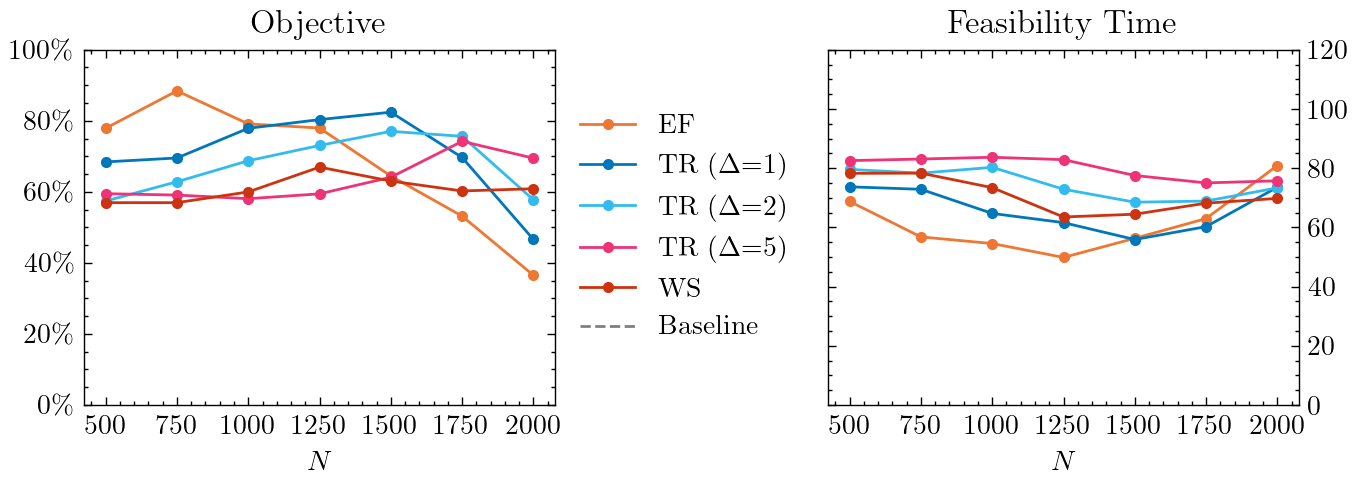

In [37]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(7, 2.625)

def make_lineplot(column, ax):
    means = df[df['heuristic'] != 'bs'].groupby(['heuristic', 'delta', 'n'])[column].mean().reset_index()
    # stds = df[df['heuristic'] != 'Baseline'].groupby(['heuristic', 'n'])['relative_objective'].std().reset_index()
    for h in means['heuristic'].unique():
        if h == 'tr':
            for delta in means[means['heuristic'] == h]['delta'].unique():
                h_means = means[(means['heuristic'] == h) & (means['delta'] == delta)].set_index('n')[column]

                ax.plot(h_means, marker='.', label=h.upper()+f' ($\Delta$={delta})')
        else:
            h_means = means[means['heuristic'] == h].set_index('n')[column]
            # h_stds = stds[stds['heuristic'] == h].set_index('n')['relative_objective']
            # plt.errorbar(h_means.index, h_means.values, yerr=h_stds.values, marker='.', label=h)
            ax.plot(h_means, marker='.', label=h.upper())

    baseline_obj = df[df['heuristic'] == 'Baseline'][column].mean()

    ax.set_xticks(means['n'].unique())

    xlim = ax.get_xlim()
    ax.hlines(baseline_obj, *xlim, label='Baseline', linestyles='dashed', color='gray')
    ax.set_xlim(*xlim)

make_lineplot('rel_obj', axs[0])

axs[0].set_ylim(0,1)
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_title('Objective')
# axs[0].set_ylabel('Relative Value')
axs[0].set_xlabel('$N$')
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

make_lineplot('time_to_feasible', axs[1])

axs[1].set_ylim(0,120)
# axs[1].legend()
# axs[1].set_ylabel('Seconds')
axs[1].set_xlabel('$N$')
axs[1].set_title('Feasibility Time')
axs[1].yaxis.tick_right()
axs[1].yaxis.set_ticks_position('both')
axs[1].yaxis.set_label_position("right")

fig.tight_layout()
fig.show()